# Student Academic Performance Prediction Model - Capstone Project - Abdulrahman Wahib

**Goal:** Predict exam scores, flag “at-risk” students, and provide advisors with simple decision support

# Project Environment / Imports:

In [3]:
# Environment
import os, sys, random, math, pathlib, json, glob, warnings
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from IPython.display import Markdown, display
import plotly.graph_objects as go
import ipywidgets as widgets
import hashlib
from pathlib import Path


# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy import stats

# KaggleHub for dataset download
import kagglehub

# Settings
np.random.seed(42)
random.seed(42)
pd.set_option("display.max_columns", 100)
pd.set_option("display.float_format", lambda v: f"{v:,.4f}")
warnings.filterwarnings("ignore") # Now warnings is defined
PRIVACY_MODE = True                 # if True, mask identifiers in displays
SALT = "change_me_per_course_run"   # rotate per cohort/term
RETENTION_DAYS = 30                 # policy statement only (no auto-delete in notebook)


print('Environment ready.')
print("Python:", sys.version.split()[0])
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("matplotlib:", plt.matplotlib.__version__)

Environment ready.
Python: 3.12.12
pandas: 2.2.2
numpy: 2.0.2
matplotlib: 3.10.0


# Project Configuration + student safety and security features:

In [4]:
CONFIG = {
    "target": "exam_score",
    "id_col": "student_id",
    "numeric_features": [
        "hours_studied",
        "sleep_hours",
        "attendance_percent",
        "previous_scores",
    ],
    # Business/UX
    "risk_threshold": 70.0,
    # Train/validation
    "test_size": 0.2,
    "cv_folds": 5,
    "random_state": 42,
}

ID_COL = CONFIG.get("id_col", "student_id")
MASK_COL = f"{ID_COL}_masked"

# Define SALT and PRIVACY_MODE before they are used
SALT = "change_me_per_course_run"   # rotate per cohort/term
PRIVACY_MODE = True                 # if True, mask identifiers in displays
RETENTION_DAYS = 30                 # policy statement only (no auto-delete in notebook)
ID_COL = CONFIG.get("id_col", "student_id")
MASK_COL = f"{ID_COL}_masked"

# Folders for artifacts
ARTIFACT_DIR = Path("./artifacts")
FIG_DIR = ARTIFACT_DIR / "figures"
MODEL_DIR = ARTIFACT_DIR / "models"
REPORT_DIR = ARTIFACT_DIR / "reports"
for p in [FIG_DIR, MODEL_DIR, REPORT_DIR]:
    p.mkdir(parents=True, exist_ok=True)

def savefig(fig, name: str, tight=True):
    """Save a matplotlib figure to artifacts/figures."""
    path = FIG_DIR / f"{name}.png"
    if tight:
        fig.tight_layout()
    fig.savefig(path, dpi=150)
    print(f"[saved] {path}")

print(json.dumps(CONFIG, indent=2))

def mask_id(value: str, salt: str = SALT) -> str:
    """Deterministic salted hash for pseudonymization."""
    if pd.isna(value):
        return value
    h = hashlib.sha256((str(value) + salt).encode("utf-8")).hexdigest()[:10]
    return f"ID_{h}"

def add_mask_column(frame: pd.DataFrame) -> pd.DataFrame:
    if ID_COL in frame.columns:
        frame = frame.copy()
        frame[MASK_COL] = frame[ID_COL].astype(str).apply(mask_id)
    return frame

def safe_display(frame: pd.DataFrame, cols=None, max_rows=20):
    """Display a masked view by default."""
    view = add_mask_column(frame)
    if PRIVACY_MODE and ID_COL in view.columns:
        # drop raw ID from display
        keep = [c for c in (cols or view.columns) if c != ID_COL]
        display(view[keep].head(max_rows))
    else:
        display(view[cols] if cols else view.head(max_rows))

def safe_export_csv(frame: pd.DataFrame, path: Path, include_ids: bool = False):
    """Export with masked IDs by default; opt-in to include raw IDs."""
    out = add_mask_column(frame)
    if PRIVACY_MODE and not include_ids and ID_COL in out.columns:
        out = out.drop(columns=[ID_COL])
    out.to_csv(path, index=False)
    print(f"[exported] {path} (masked_ids={'yes' if (PRIVACY_MODE and not include_ids) else 'no'})")

# Add interactive toggle for privacy mode
privacy_toggle = widgets.ToggleButton(
    value=True,  # Initially True
    description='Privacy Mode (Mask IDs)',
    disabled=False,
    button_style='info',
    tooltip='Toggle to show/hide student IDs',
    icon='lock' if PRIVACY_MODE else 'unlock',
    layout=widgets.Layout(width='200px') # Adjust width here
)

out_privacy = widgets.Output()

def update_privacy_mode(change):
    global PRIVACY_MODE
    PRIVACY_MODE = change['new']
    with out_privacy:
        out_privacy.clear_output(wait=True)
        print(f"Privacy Mode is now: {PRIVACY_MODE}")
    # Update button icon
    privacy_toggle.icon = 'lock' if PRIVACY_MODE else 'unlock'


privacy_toggle.observe(update_privacy_mode, names='value')

display(Markdown("### Privacy Settings"))
display(privacy_toggle, out_privacy)

# Initial print of privacy mode state
with out_privacy:
    print(f"Privacy Mode is initially: {PRIVACY_MODE}")

{
  "target": "exam_score",
  "id_col": "student_id",
  "numeric_features": [
    "hours_studied",
    "sleep_hours",
    "attendance_percent",
    "previous_scores"
  ],
  "risk_threshold": 70.0,
  "test_size": 0.2,
  "cv_folds": 5,
  "random_state": 42
}


### Privacy Settings

ToggleButton(value=True, button_style='info', description='Privacy Mode (Mask IDs)', icon='lock', layout=Layou…

Output()

# Adding the data:

In [5]:
# Download the Kaggle dataset
kaggle_path = kagglehub.dataset_download("saadaliyaseen/analyzing-student-academic-trends")
print("[kagglehub] downloaded to:", kaggle_path)

expected_csv = os.path.join(kaggle_path, "student_exam_scores.csv")

print(f"[select] Using CSV: {expected_csv}")

df = pd.read_csv(expected_csv)
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

required_cols = [
    "student_id",
    "hours_studied",
    "sleep_hours",
    "attendance_percent",
    "previous_scores",
    "exam_score",
]

def mem_mb(frame):
    return frame.memory_usage(deep=True).sum() / (1024**2)

print("")
display(Markdown("<font color='cyan'>**Note:** To display student IDs in the table below, turn off Privacy Mode using the toggle button in the \"Privacy Settings\" section.</font>"))

print("\n=== Dataset Snapshot ===")
print("shape:", df.shape, "| memory (MB):", f"{mem_mb(df):.3f}")
# Adjust display to comply with privacy status
safe_display(df, max_rows=12)

print("\n=== Column Dtypes ===")
print(df.dtypes)

100%|██████████| 2.37k/2.37k [00:00<00:00, 7.26MB/s]

Extracting files...
[kagglehub] downloaded to: /root/.cache/kagglehub/datasets/saadaliyaseen/analyzing-student-academic-trends/versions/1
[select] Using CSV: /root/.cache/kagglehub/datasets/saadaliyaseen/analyzing-student-academic-trends/versions/1/student_exam_scores.csv



<font color='cyan'>**Note:** To display student IDs in the table below, turn off Privacy Mode using the toggle button in the "Privacy Settings" section.</font>


=== Dataset Snapshot ===
shape: (200, 6) | memory (MB): 0.018


,hours_studied,sleep_hours,attendance_percent,previous_scores,exam_score,student_id_masked
0,8.0000,8.8000,72.1000,45,30.2000,ID_3fcaac7275
1,1.3000,8.6000,60.7000,55,25.0000,ID_9f6d445bea
2,4.0000,8.2000,73.7000,86,35.8000,ID_8e880eab09
3,3.5000,4.8000,95.1000,66,34.0000,ID_9d9acc47de
4,9.1000,6.4000,89.8000,71,40.3000,ID_76178dc40c
5,8.4000,5.1000,58.5000,75,35.7000,ID_3d3de92f54
6,10.8000,6.0000,54.2000,88,37.9000,ID_5fe7b9917d
7,2.0000,4.3000,75.8000,55,18.3000,ID_d77379583a
8,5.6000,5.9000,81.6000,84,34.7000,ID_7b68653b51
9,1.3000,8.9000,66.8000,70,24.7000,ID_57b52a7e27



=== Column Dtypes ===
student_id             object
hours_studied         float64
sleep_hours           float64
attendance_percent    float64
previous_scores         int64
exam_score            float64
dtype: object


# Validating the data:

In [6]:
# Keep an untouched copy for before/after comparisons
df_raw = df.copy(deep=True)

# ---- Expectations / Valid Ranges ----
BOUNDS = {
    "attendance_percent": (0.0, 100.0),
    "hours_studied": (0.0, np.inf),   # only lower bound
    "sleep_hours": (0.0, 24.0),
    "previous_scores": (0.0, 100.0),
    "exam_score": (0.0, 100.0),
}
ID_COL = "student_id"

# ---- Helper functions ----
def missing_table(frame: pd.DataFrame) -> pd.DataFrame:
    miss_ct = frame.isna().sum()
    miss_pct = 100 * miss_ct / len(frame) if len(frame) else 0
    out = pd.DataFrame({"missing_count": miss_ct, "missing_pct": miss_pct})
    return out.sort_values("missing_pct", ascending=False)

def range_violations(frame: pd.DataFrame, bounds: dict) -> pd.DataFrame:
    rows = []
    for col, (lo, hi) in bounds.items():
        if col not in frame.columns:
            rows.append((col, "not_found", np.nan))
            continue
        s = pd.to_numeric(frame[col], errors="coerce")
        if np.isinf(hi):
            bad = (s < lo)
        else:
            bad = (s < lo) | (s > hi)
        rows.append((col, "violations", int(bad.sum())))
    return pd.DataFrame(rows, columns=["column", "check", "value"]).set_index(["column","check"])

def duplicate_checks(frame: pd.DataFrame, id_col: str) -> pd.DataFrame:
    rows = []
    # exact duplicate rows
    rows.append(("__rows__", "exact_duplicate_rows", int(frame.duplicated(keep="first").sum())))
    # duplicate IDs
    if id_col in frame.columns:
        rows.append((id_col, "duplicate_ids", int(frame.duplicated(subset=[id_col], keep="first").sum())))
    else:
        rows.append((id_col, "duplicate_ids", np.nan))
    return pd.DataFrame(rows, columns=["column", "check", "value"]).set_index(["column","check"])

def make_dq_report(frame: pd.DataFrame) -> pd.DataFrame:
    miss = missing_table(frame).rename_axis("column")
    rng = range_violations(frame, BOUNDS).reset_index()
    dups = duplicate_checks(frame, ID_COL).reset_index()

    # Flatten to a single report
    rep = miss.reset_index()
    rep["missing_pct"] = rep["missing_pct"].round(2)

    # Merge in violations
    rng_wide = rng.pivot(index="column", columns="check", values="value").reset_index()
    dups_wide = dups.pivot(index="column", columns="check", values="value").reset_index()

    dq = rep.merge(rng_wide, on="column", how="outer").merge(dups_wide, on="column", how="outer")

    # Pass/Fail flags
    def pass_fail(row):
        violations = row.get("violations", 0)
        missing = row.get("missing_count", 0)
        dup_rows = row.get("exact_duplicate_rows", 0)
        dup_ids = row.get("duplicate_ids", 0)
        any_issue = False
        for v in [violations, missing, dup_rows, dup_ids]:
            if pd.notna(v) and v > 0:
                any_issue = True
        return "PASS" if not any_issue else "FAIL"

    dq["status"] = dq.apply(pass_fail, axis=1)
    dq = dq.sort_values(["status", "missing_pct"], ascending=[True, False]).reset_index(drop=True)
    return dq

# ---- Run Checks ----
dq_report = make_dq_report(df_raw)

print("=== Data Quality Report ===")
display(dq_report.fillna(0))

# Summarize issues to auto-fix
issues = {
    "missing_total": int(df_raw.isna().sum().sum()),
    "range_violations": {c: int(((pd.to_numeric(df_raw[c], errors="coerce") < lo) |
                                 ((~np.isinf(hi)) & (pd.to_numeric(df_raw[c], errors="coerce") > hi))).sum())
                         for c, (lo, hi) in BOUNDS.items() if c in df_raw.columns},
    "exact_duplicate_rows": int(df_raw.duplicated(keep="first").sum()),
    "duplicate_ids": int(df_raw.duplicated(subset=[ID_COL], keep="first").sum()) if ID_COL in df_raw.columns else np.nan,
}

print("\n=== Issues Summary ===")
# Check if any issues were found
if issues["missing_total"] == 0 and \
   issues["exact_duplicate_rows"] == 0 and \
   (pd.isna(issues["duplicate_ids"]) or issues["duplicate_ids"] == 0) and \
   all(v == 0 for v in issues.get("range_violations", {}).values()):
    print("No issues found.")
else:
    print(issues)

=== Data Quality Report ===


,column,missing_count,missing_pct,violations,duplicate_ids,exact_duplicate_rows,status
0,attendance_percent,0.0000,0.0000,0.0000,0.0000,0.0000,PASS
1,exam_score,0.0000,0.0000,0.0000,0.0000,0.0000,PASS
2,hours_studied,0.0000,0.0000,0.0000,0.0000,0.0000,PASS
3,previous_scores,0.0000,0.0000,0.0000,0.0000,0.0000,PASS
4,sleep_hours,0.0000,0.0000,0.0000,0.0000,0.0000,PASS
5,student_id,0.0000,0.0000,0.0000,0.0000,0.0000,PASS
6,__rows__,0.0000,0.0000,0.0000,0.0000,0.0000,PASS



=== Issues Summary ===
No issues found.


# Descriptive EDA:


**KPI Snapshot**
- Dataset size: **200** students
- Average exam score: **33.95**


[saved] artifacts/figures/eda_histograms.png


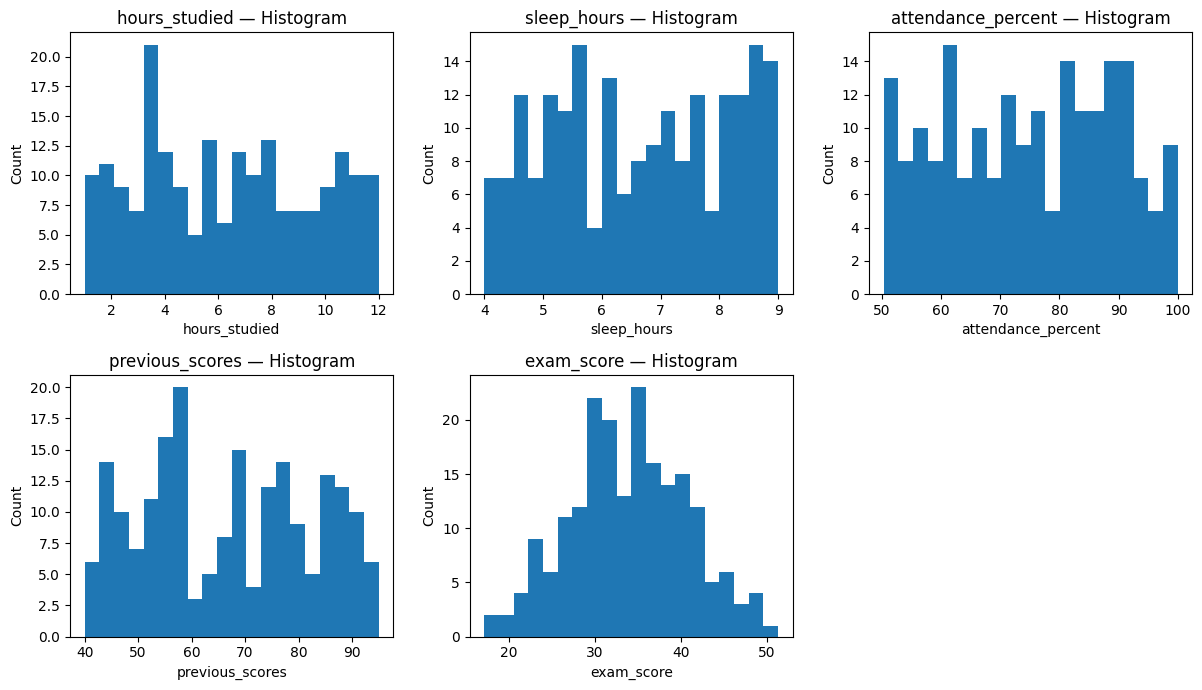

[saved] artifacts/figures/eda_boxplots.png


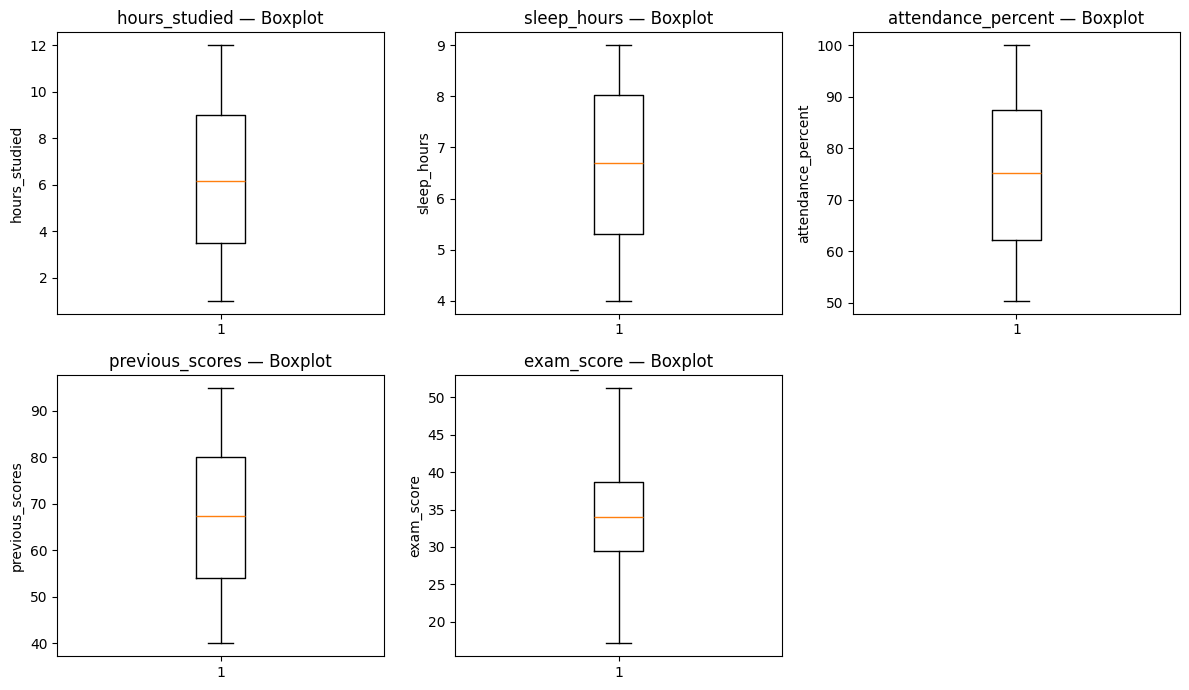

[saved] artifacts/figures/scatter_hours_studied_vs_exam_score.html
[saved] artifacts/figures/scatter_sleep_hours_vs_exam_score.html
[saved] artifacts/figures/scatter_attendance_percent_vs_exam_score.html
[saved] artifacts/figures/scatter_previous_scores_vs_exam_score.html
[saved] artifacts/figures/eda_correlation_heatmap.png


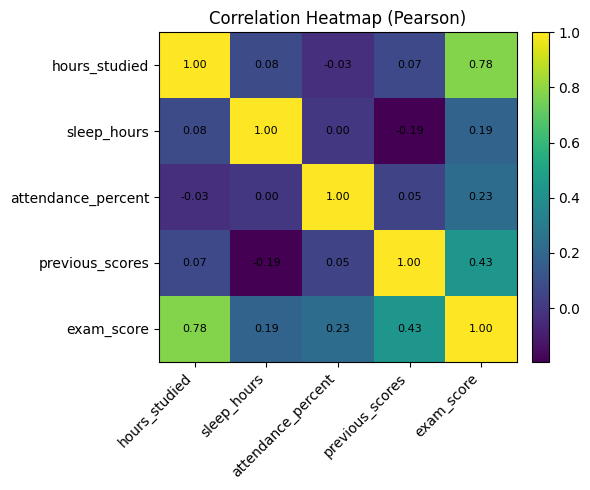


**Band Distributions**
- Attendance: {'<70': 78, '70–85': 62, '>85': 60}
- Study: {'>6': 101, '3–6': 64, '0–3': 35}
- Sleep: {'<6': 81, '6–8': 69, '>8': 50}


In [7]:
NUMS = CONFIG["numeric_features"]
TARGET = CONFIG["target"]

# ---------- KPI tiles ----------
n_rows = len(df)
avg_score = df[TARGET].mean()
kpi_md = f"""
**KPI Snapshot**
- Dataset size: **{n_rows:,}** students
- Average exam score: **{avg_score:0.2f}**
"""
display(Markdown(kpi_md))

# ---------- Univariate: histograms ----------
fig, axes = plt.subplots(2, 3, figsize=(12, 7))
axes = axes.ravel()
cols = NUMS + [TARGET]
for i, col in enumerate(cols):
    ax = axes[i]
    ax.hist(df[col].dropna().values, bins=20)
    ax.set_title(f"{col} — Histogram")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
# Hide any unused subplot
for j in range(len(cols), len(axes)):
    axes[j].axis("off")
savefig(fig, "eda_histograms")
plt.show(fig)

# ---------- Univariate: boxplots ----------
fig2, axes2 = plt.subplots(2, 3, figsize=(12, 7))
axes2 = axes2.ravel()
for i, col in enumerate(cols):
    ax = axes2[i]
    ax.boxplot(df[col].dropna().values, vert=True)
    ax.set_title(f"{col} — Boxplot")
    ax.set_ylabel(col)
for j in range(len(cols), len(axes2)):
    axes2[j].axis("off")
savefig(fig2, "eda_boxplots")
plt.show(fig2)

# ---------- Bivariate with target: scatter + linear trend ----------
def scatter_with_trend(xcol, ycol=TARGET, title=None):
    # Base scatter
    fig = px.scatter(df, x=xcol, y=ycol, opacity=0.7, title=title or f"{xcol} vs {ycol}")
    # Add simple linear trendline using numpy polyfit
    x = df[xcol].values
    y = df[ycol].values
    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() > 1:
        coeffs = np.polyfit(x[mask], y[mask], deg=1)
        x_line = np.linspace(x[mask].min(), x[mask].max(), 200)
        y_line = coeffs[0] * x_line + coeffs[1]
        fig.add_trace(go.Scatter(x=x_line, y=y_line, mode="lines", name="Linear trend"))
    # Save HTML for later dashboard reuse
    out_path = FIG_DIR / f"scatter_{xcol}_vs_{ycol}.html"
    fig.write_html(str(out_path))
    print(f"[saved] {out_path}")
    return fig

_ = scatter_with_trend("hours_studied", TARGET, "Hours Studied vs Exam Score")
_ = scatter_with_trend("sleep_hours", TARGET, "Sleep Hours vs Exam Score")
_ = scatter_with_trend("attendance_percent", TARGET, "Attendance % vs Exam Score")
_ = scatter_with_trend("previous_scores", TARGET, "Previous Scores vs Exam Score")

# ---------- Correlation heatmap ----------
num_only = df[NUMS + [TARGET]].copy()
corr = num_only.corr(method="pearson")

fig3, ax3 = plt.subplots(figsize=(6, 5))
im = ax3.imshow(corr, aspect="auto")
ax3.set_xticks(range(corr.shape[1])); ax3.set_xticklabels(corr.columns, rotation=45, ha="right")
ax3.set_yticks(range(corr.shape[0])); ax3.set_yticklabels(corr.index)
ax3.set_title("Correlation Heatmap (Pearson)")
cbar = plt.colorbar(im, ax=ax3, fraction=0.046, pad=0.04)
for (i, j), val in np.ndenumerate(corr.values):
    ax3.text(j, i, f"{val:0.2f}", ha="center", va="center", fontsize=8)
savefig(fig3, "eda_correlation_heatmap")
plt.show(fig3)

# ---------- Segment bands & cohort table ----------
df["attendance_band"] = pd.cut(
    df["attendance_percent"],
    bins=[-np.inf, 70, 85, np.inf],
    labels=["<70", "70–85", ">85"]
)
df["study_band"] = pd.cut(
    df["hours_studied"],
    bins=[-np.inf, 3, 6, np.inf],
    labels=["0–3", "3–6", ">6"]
)
df["sleep_band"] = pd.cut(
    df["sleep_hours"],
    bins=[-np.inf, 6, 8, np.inf],
    labels=["<6", "6–8", ">8"]
)

# Band distributions for KPIs
band_md = f"""
**Band Distributions**
- Attendance: {df['attendance_band'].value_counts(dropna=False).to_dict()}
- Study: {df['study_band'].value_counts(dropna=False).to_dict()}
- Sleep: {df['sleep_band'].value_counts(dropna=False).to_dict()}
"""
display(Markdown(band_md))

# Feature Engineering:

In [8]:
# 1) Keep originals and bands, Ensure they exist.
for col, bins, labels in [
    ("attendance_percent", [-np.inf, 70, 85, np.inf], ["<70", "70–85", ">85"]),
    ("hours_studied",     [-np.inf, 3, 6, np.inf],    ["0–3", "3–6", ">6"]),
    ("sleep_hours",       [-np.inf, 6, 8, np.inf],    ["<6", "6–8", ">8"]),
]:
    band_col = {"attendance_percent":"attendance_band",
                "hours_studied":"study_band",
                "sleep_hours":"sleep_band"}[col]
    if band_col not in df.columns:
        df[band_col] = pd.cut(df[col], bins=bins, labels=labels)

# 2) Optional interaction term
df["hours_x_attendance"] = df["hours_studied"] * df["attendance_percent"]

# 3) One-hot encode bands
band_cols = ["attendance_band", "study_band", "sleep_band"]
df = pd.get_dummies(df, columns=band_cols, prefix=band_cols, drop_first=False)

# 4) Assemble X (features) and y (target)
continuous_features = CONFIG["numeric_features"] + ["hours_x_attendance"]
categorical_dummies = [c for c in df.columns if c.startswith("attendance_band_")
                       or c.startswith("study_band_")
                       or c.startswith("sleep_band_")]

FEATURES = continuous_features + categorical_dummies
X = df[FEATURES].copy()
y = df[CONFIG["target"]].copy()

# 5) Output preview
print("=== Feature Matrix (X) dtypes ===")
print(X.dtypes)

print("\n=== Feature Matrix (X) preview ===")
display(X.head())

print("\n=== Target (y) preview ===")
display(y.head())

print(f"\n[status] Assembled X with {X.shape[1]} features and {X.shape[0]} rows.")

=== Feature Matrix (X) dtypes ===
hours_studied            float64
sleep_hours              float64
attendance_percent       float64
previous_scores            int64
hours_x_attendance       float64
attendance_band_<70         bool
attendance_band_70–85       bool
attendance_band_>85         bool
study_band_0–3              bool
study_band_3–6              bool
study_band_>6               bool
sleep_band_<6               bool
sleep_band_6–8              bool
sleep_band_>8               bool
dtype: object

=== Feature Matrix (X) preview ===


,hours_studied,sleep_hours,attendance_percent,previous_scores,hours_x_attendance,attendance_band_<70,attendance_band_70–85,attendance_band_>85,study_band_0–3,study_band_3–6,study_band_>6,sleep_band_<6,sleep_band_6–8,sleep_band_>8
0,8.0000,8.8000,72.1000,45,576.8000,False,True,False,False,False,True,False,False,True
1,1.3000,8.6000,60.7000,55,78.9100,True,False,False,True,False,False,False,False,True
2,4.0000,8.2000,73.7000,86,294.8000,False,True,False,False,True,False,False,False,True
3,3.5000,4.8000,95.1000,66,332.8500,False,False,True,False,True,False,True,False,False
4,9.1000,6.4000,89.8000,71,817.1800,False,False,True,False,False,True,False,True,False



=== Target (y) preview ===


,exam_score
0,30.2000
1,25.0000
2,35.8000
3,34.0000
4,40.3000



[status] Assembled X with 14 features and 200 rows.


# Train/Test Split:

In [9]:
assert CONFIG["target"] not in X.columns, "Leakage: 'exam_score' found in X!"

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=CONFIG["test_size"],
    random_state=CONFIG["random_state"]
)

print("=== Train/Test Shapes ===")
print("X_train:", X_train.shape, " | y_train:", y_train.shape)
print("X_test :", X_test.shape,  " | y_test :", y_test.shape)

=== Train/Test Shapes ===
X_train: (160, 14)  | y_train: (160,)
X_test : (40, 14)  | y_test : (40,)


# Baseline & Predictive Pipelines (machine learning):

In [10]:
# ---------- Preprocessor: standardize continuous ----------
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), continuous_features),
        ("cat", "passthrough", categorical_dummies),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

def evaluate(model, Xtr, ytr, Xte, yte, label: str):
    """Fit model, eval on test, print MAE/RMSE (RMSE via sqrt of MSE)."""
    model.fit(Xtr, ytr)
    preds = model.predict(Xte)
    mae = mean_absolute_error(yte, preds)
    mse = mean_squared_error(yte, preds)
    rmse = np.sqrt(mse)
    print(f"{label:>20} | MAE: {mae:6.3f} | RMSE: {rmse:6.3f}")
    return {"model": label, "MAE": mae, "RMSE": rmse, "estimator": model}

metrics_list = []

# ---------- Baseline: Dummy (mean) ----------
pipe_dummy = Pipeline([
    ("prep", preprocess),
    ("model", DummyRegressor(strategy="mean"))
])
metrics_list.append(evaluate(pipe_dummy, X_train, y_train, X_test, y_test, "Baseline Dummy (mean)"))

# ---------- Model 1: Linear Regression ----------
pipe_lin = Pipeline([
    ("prep", preprocess),
    ("model", LinearRegression())
])
metrics_list.append(evaluate(pipe_lin, X_train, y_train, X_test, y_test, "Linear Regression"))

# ---------- Model 2: Ridge (small alpha grid via CV on MAE) ----------
ridge_pipe = Pipeline([
    ("prep", preprocess),
    ("model", Ridge())
])

param_grid = {"model__alpha": [0.0, 0.1, 1.0, 10.0]}
ridge_cv = GridSearchCV(
    estimator=ridge_pipe,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",
    cv=CONFIG["cv_folds"],
    n_jobs=-1,
    return_train_score=True
)

ridge_cv.fit(X_train, y_train)
best_ridge = ridge_cv.best_estimator_
best_params = ridge_cv.best_params_
best_cv_mae = -ridge_cv.best_score_

print("\n=== Ridge CV Summary ===")
cv_df = pd.DataFrame(ridge_cv.cv_results_)[
    ["param_model__alpha", "mean_train_score", "mean_test_score", "std_test_score"]
].rename(columns={
    "param_model__alpha": "alpha",
    "mean_train_score": "cv_mean_train_negMAE",
    "mean_test_score": "cv_mean_test_negMAE",
    "std_test_score": "cv_std_test_negMAE"
})
# Convert back to MAE (+ sign)
cv_df["cv_mean_train_MAE"] = -cv_df["cv_mean_train_negMAE"]
cv_df["cv_mean_test_MAE"]  = -cv_df["cv_mean_test_negMAE"]
cv_df = cv_df.drop(columns=["cv_mean_train_negMAE","cv_mean_test_negMAE","cv_std_test_negMAE"]).sort_values("cv_mean_test_MAE")
display(cv_df)

print(f"[ridge] Best params: {best_params} | CV MAE: {best_cv_mae:.3f}")

# Evaluate best Ridge on test
ridge_preds = best_ridge.predict(X_test)
ridge_mae  = mean_absolute_error(y_test, ridge_preds)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_preds))
print(f"{'Ridge (best)'.rjust(20)} | MAE: {ridge_mae:6.3f} | RMSE: {ridge_rmse:6.3f}")
metrics_list.append({"model": "Ridge (best)", "MAE": ridge_mae, "RMSE": ridge_rmse, "estimator": best_ridge})


# ---------- Random Forest ----------
try:
    pipe_rf = Pipeline([
        ("prep", preprocess),
        ("model", RandomForestRegressor(
            n_estimators=300,
            max_depth=4,
            random_state=CONFIG["random_state"],
            n_jobs=-1
        ))
    ])
    metrics_list.append(evaluate(pipe_rf, X_train, y_train, X_test, y_test, "RandomForest (depth=4)"))
except Exception as e:
    print("[warn] RandomForest run skipped:", e)

# ---------- Consolidated results ----------
results_df = pd.DataFrame([{k:v for k,v in m.items() if k != "estimator"} for m in metrics_list]).sort_values("MAE")
print("\n=== Test Set Metrics (sorted by MAE) ===")
display(results_df.reset_index(drop=True))

# Keep handles to best models for later steps
best_row = results_df.iloc[0]
best_estimator = metrics_list[results_df.index[0]]["estimator"]

print(f"[winner] Best on test by MAE: {best_row['model']}")

Baseline Dummy (mean) | MAE:  6.120 | RMSE:  7.303
   Linear Regression | MAE:  2.366 | RMSE:  2.770

=== Ridge CV Summary ===


,alpha,cv_mean_train_MAE,cv_mean_test_MAE
1,0.1000,2.1752,2.3432
2,1.0000,2.1919,2.3445
3,10.0000,2.2636,2.3618
0,0.0000,2.1823,2.3932


[ridge] Best params: {'model__alpha': 0.1} | CV MAE: 2.343
        Ridge (best) | MAE:  2.367 | RMSE:  2.772
RandomForest (depth=4) | MAE:  2.753 | RMSE:  3.143

=== Test Set Metrics (sorted by MAE) ===


,model,MAE,RMSE
0,Linear Regression,2.3660,2.7701
1,Ridge (best),2.3672,2.7719
2,RandomForest (depth=4),2.7530,3.1427
3,Baseline Dummy (mean),6.1199,7.3034


[winner] Best on test by MAE: Linear Regression


# Evaluation and Student Score Forecasting Interactive Graph:

[saved] artifacts/figures/residuals_vs_predicted.png


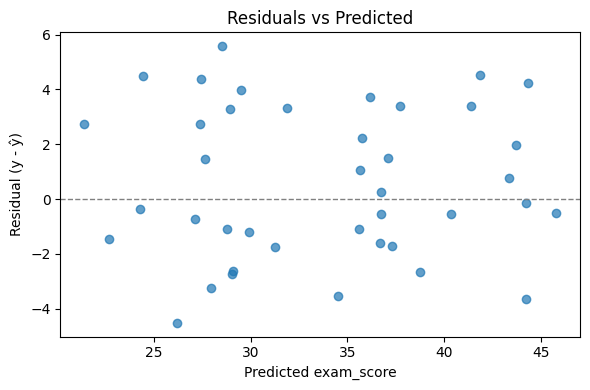

[saved] artifacts/figures/qq_plot_residuals.png


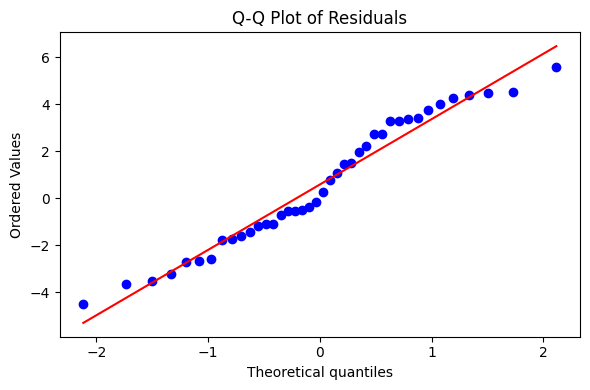

### Interactive What-If Predictor

Adjust the sliders to simulate a student's inputs. The gauge shows the predicted exam score.

Output()

In [11]:
# --- Residual diagnostics (test set) ---
assert "best_estimator" in globals(), "best_estimator not found. Run Cell 9 first."

best_pipe = best_estimator  # fitted Pipeline(prep -> model)

y_pred = best_pipe.predict(X_test)
residuals = y_test - y_pred

# Residuals vs Predicted
fig_res, ax_res = plt.subplots(figsize=(6,4))
ax_res.scatter(y_pred, residuals, alpha=0.7)
ax_res.axhline(0, color="gray", linestyle="--", linewidth=1)
ax_res.set_xlabel("Predicted exam_score")
ax_res.set_ylabel("Residual (y - ŷ)")
ax_res.set_title("Residuals vs Predicted")
savefig(fig_res, "residuals_vs_predicted")
plt.show(fig_res)

# Q-Q plot of residuals
fig_qq, ax_qq = plt.subplots(figsize=(6,4))
stats.probplot(residuals, dist="norm", plot=ax_qq)
ax_qq.set_title("Q-Q Plot of Residuals")
savefig(fig_qq, "qq_plot_residuals")
plt.show(fig_qq)

# --- Interactive predictor ---

# Build a deduplicated feature order that matches the pipeline selectors
continuous_features_for_order = [f for f in continuous_features if f not in ["hours_x_attendance"]]
FEATURE_ORDER = list(dict.fromkeys(continuous_features_for_order + ["hours_x_attendance"] + categorical_dummies))


ATT_BINS  = [-np.inf, 70, 85, np.inf]
ATT_LABEL = ["<70", "70–85", ">85"]
STU_BINS  = [-np.inf, 3, 6, np.inf]
STU_LABEL = ["0–3", "3–6", ">6"]
SLP_BINS  = [-np.inf, 6, 8, np.inf]
SLP_LABEL = ["<6", "6–8", ">8"]

def build_feature_row(hours, sleep, attendance, prev, feature_order):
    base = pd.DataFrame([{
        "hours_studied": float(hours),
        "sleep_hours": float(sleep),
        "attendance_percent": float(attendance),
        "previous_scores": float(prev),
    }])

    base["attendance_band"] = pd.cut(base["attendance_percent"], bins=ATT_BINS, labels=ATT_LABEL)
    base["study_band"]      = pd.cut(base["hours_studied"],     bins=STU_BINS, labels=STU_LABEL)
    base["sleep_band"]      = pd.cut(base["sleep_hours"],       bins=SLP_BINS, labels=SLP_LABEL)

    # Interaction
    base["hours_x_attendance"] = base["hours_studied"] * base["attendance_percent"]

    # One-hot dummies
    dums = pd.get_dummies(
        base[["attendance_band","study_band","sleep_band"]],
        prefix=["attendance_band","study_band","sleep_band"],
        drop_first=False
    )

    # Combine continuous + interaction + dummies, ensuring unique columns
    cont = base[[col for col in continuous_features + ["hours_x_attendance"] if col in base.columns]] # Ensure columns exist
    all_cols = cont.columns.tolist() + dums.columns.tolist()
    X_row = pd.concat([cont, dums], axis=1)
    # Ensure columns are unique in X_row before reindexing
    X_row = X_row.loc[:, ~X_row.columns.duplicated()]


    # Align strictly to the pipeline feature order (deduped), fill missing with 0
    X_row = X_row.reindex(columns=feature_order, fill_value=0)
    return X_row

# Sliders
slider_style = {'handle_color': '#17a2b8'}
w_hours      = widgets.FloatSlider(description="Hours studied", min=0, max=12, step=0.1, value=5.0, continuous_update=False, style=slider_style)
w_sleep      = widgets.FloatSlider(description="Sleep hours",   min=0, max=12, step=0.1, value=7.0, continuous_update=False, style=slider_style)
w_attendance = widgets.FloatSlider(description="Attendance %",  min=0, max=100, step=0.1, value=80.0, continuous_update=False, style=slider_style)
w_prev       = widgets.FloatSlider(description="Prev. score",   min=0, max=100, step=0.5, value=70.0, continuous_update=False, style=slider_style)


# Calibrate a realistic threshold from TRAIN labels
# Defaults to the training 25th percentile; adjust to ~20–30% to fit circumstance needs
CALIBRATION_PERCENTILE = 0.25
data_driven_threshold = float(y_train.quantile(CALIBRATION_PERCENTILE))
CONFIG["risk_threshold"] = data_driven_threshold
risk_threshold = data_driven_threshold

EXAM_MIN = float(y.min())
EXAM_MAX = float(y.max())
PAD = max(1.0, 0.05 * (EXAM_MAX - EXAM_MIN))
GAUGE_MIN = EXAM_MIN - PAD
GAUGE_MAX = EXAM_MAX + PAD


out_pred = widgets.Output()

def render_prediction(hours, sleep, attendance, prev):
    X_row = build_feature_row(hours, sleep, attendance, prev, FEATURE_ORDER)
    pred = float(best_estimator.predict(X_row)[0])

    fig = go.Figure(go.Indicator(
        mode="gauge+number",
        value=pred,
        number={"suffix": " pts"},
        title={"text": "Predicted Exam Score"},
        gauge={
            "axis": {"range": [GAUGE_MIN, GAUGE_MAX]}, # Use data-driven range
            "bar": {"thickness": 0.3},
            "threshold": {"line": {"width": 3}, "thickness": 0.9, "value": risk_threshold}
        }
    ))
    fig.update_layout(height=300, margin=dict(l=30, r=30, t=50, b=30))

    status = "✅ Above threshold" if pred >= risk_threshold else "⚠️ At risk"
    summary = (
        f"**Inputs** — Hours: {hours:.1f}, Sleep: {sleep:.1f}, Attendance: {attendance:.1f}%, Prev: {prev:.1f}\n\n"
        f"**Predicted score:** **{pred:.2f}** points  •  Threshold: {risk_threshold:.1f}  →  {status}"
    )

    with out_pred:
        out_pred.clear_output(wait=True)
        display(Markdown(summary))
        fig.show()

ui = widgets.VBox([w_hours, w_sleep, w_attendance, w_prev])
ctrl = widgets.interactive_output(render_prediction, {
    "hours": w_hours, "sleep": w_sleep, "attendance": w_attendance, "prev": w_prev
})

display(Markdown("### Interactive What-If Predictor"))
display(Markdown("Adjust the sliders to simulate a student's inputs. The gauge shows the predicted exam score."))
display(ui, out_pred)

# Initial render
render_prediction(w_hours.value, w_sleep.value, w_attendance.value, w_prev.value)

# Advisor tool that help's identify student's with academic risk:

In [12]:
assert "best_estimator" in globals(), "best_estimator not found. Run Cell 9 first."
assert "risk_threshold" in globals(), "risk_threshold not found. Run Cell 10 first."
assert all(x in globals() for x in ["X_test","y_test"]), "Run Cell 8 first."

# Predict on ALL students
y_pred_all = best_estimator.predict(X)

# Define at-risk by threshold on *predicted* score for ALL students
at_risk_pred_all = (y_pred_all < risk_threshold).astype(int)

# Ground truth "risk" using the *actual* exam scores vs same threshold for ALL students
at_risk_true_all = (y < risk_threshold).astype(int)

# Calculate at_risk status for the TEST set for classification metrics
y_pred_test = best_estimator.predict(X_test)
at_risk_pred_test = (y_pred_test < risk_threshold).astype(int)
at_risk_true_test = (y_test < risk_threshold).astype(int)

# Classification-style metrics on TEST
prec = precision_score(at_risk_true_test, at_risk_pred_test, zero_division=0)
rec  = recall_score(at_risk_true_test, at_risk_pred_test, zero_division=0)
f1   = f1_score(at_risk_true_test, at_risk_pred_test, zero_division=0)
cm   = confusion_matrix(at_risk_true_test, at_risk_pred_test, labels=[1,0])

print("=== At-Risk Classification View (TEST) ===")
print(f"Threshold: {risk_threshold:.2f}")
print(f"Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")
print("\nConfusion Matrix (rows=true, cols=pred) [AtRisk=1, Not=0]:\n", cm)
print("\nDetailed report:")
print(classification_report(at_risk_true_test, at_risk_pred_test, target_names=['Not at risk','At risk'], labels=[1,0], zero_division=0)) # Added labels parameter

# ---- Triage Table for Advisors (ALL students) ----
# Pull identifiers and a few drivers from the original df
id_col = CONFIG.get("id_col", "student_id")
cols_for_view = [c for c in ["hours_studied","attendance_percent","sleep_hours","previous_scores"] if c in df.columns]

# Use the full df for the triage table
triage = (df[[id_col] + cols_for_view]
            .assign(predicted_score=y_pred_all,
                    at_risk=at_risk_pred_all,
                    actual_score=y,
                    actual_at_risk=at_risk_true_all,
                    risk_threshold=risk_threshold))

# Simple rule flags to guide conversation
triage["flag_low_attendance"] = (triage["attendance_percent"] < 70).astype(int) if "attendance_percent" in triage.columns else 0
triage["flag_low_study"]      = (triage["hours_studied"] < 3).astype(int) if "hours_studied" in triage.columns else 0
triage["flag_low_sleep"]      = (triage["sleep_hours"] < 6).astype(int) if "sleep_hours" in triage.columns else 0
triage["flag_low_prev"]       = (triage["previous_scores"] < risk_threshold).astype(int) if "previous_scores" in triage.columns else 0


# Add toggle button for sorting
sort_toggle = widgets.ToggleButton(
    value=False,
    description='Sort by Risk Status',
    disabled=False,
    button_style='info',
    tooltip='Click to sort by at_risk status',
    icon='sort-amount-up'
)

display(Markdown("<font color='cyan'>**Note:** To display student IDs in the table below, turn off Privacy Mode using the toggle button in the \"Privacy Settings\" section.</font>"))


out_triage = widgets.Output()

def display_triage_table(sort_by_risk):
    display_triage = triage.copy()
    if sort_by_risk:
        # Sort by predicted risk first, then by predicted score
        display_triage = display_triage.sort_values(["at_risk", "predicted_score"], ascending=[False, True]).reset_index(drop=True)
        sort_toggle.description = 'Sort by Student ID'
        sort_toggle.icon = 'user'
    else:
        # Ensure sorting by the defined id_col
        display_triage = display_triage.sort_values([id_col], ascending=[True]).reset_index(drop=True)
        sort_toggle.description = 'Sort by Risk Status'
        sort_toggle.icon = 'sort-amount-up'

    with out_triage:
        out_triage.clear_output(wait=True)
        print("=== Advisor Triage ===")
        # Display only the first 15 rows in the notebook output
        safe_display(display_triage, max_rows=15)

display(Markdown("### Advisor Triage Tool"))
display(Markdown("Use the toggle to sort the table by predicted risk status."))
display(sort_toggle, out_triage)


# Link toggle to display function
widgets.interactive_output(display_triage_table, {'sort_by_risk': sort_toggle})


# Save for stakeholders (save the full triage table with unmasked IDs)
REPORT_DIR.mkdir(parents=True, exist_ok=True)
triage_path = REPORT_DIR / "triage.csv"
safe_export_csv(triage, triage_path, include_ids=True)

=== At-Risk Classification View (TEST) ===
Threshold: 29.77
Precision: 0.688 | Recall: 0.846 | F1: 0.759

Confusion Matrix (rows=true, cols=pred) [AtRisk=1, Not=0]:
 [[11  2]
 [ 5 22]]

Detailed report:
              precision    recall  f1-score   support

 Not at risk       0.69      0.85      0.76        13
     At risk       0.92      0.81      0.86        27

    accuracy                           0.82        40
   macro avg       0.80      0.83      0.81        40
weighted avg       0.84      0.82      0.83        40



<font color='cyan'>**Note:** To display student IDs in the table below, turn off Privacy Mode using the toggle button in the "Privacy Settings" section.</font>

### Advisor Triage Tool

Use the toggle to sort the table by predicted risk status.

ToggleButton(value=False, button_style='info', description='Sort by Risk Status', icon='sort-amount-up', toolt…

Output()

[exported] artifacts/reports/triage.csv (masked_ids=no)


# Accuracy evaluation + Monitoring utilities:

In [13]:
assert "best_estimator" in globals(), "Run Cell 9 first."
assert all(x in globals() for x in ["X_train","y_train","X_test","y_test"]), "Run Cell 8 first."

ARTIFACT_DIR.mkdir(exist_ok=True)
REPORT_DIR.mkdir(parents=True, exist_ok=True)

def eval_metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    eps = 1e-8
    mape = (np.abs((y_true - y_pred) / (np.abs(y_true) + eps))).mean() * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE_pct": mape}

def bootstrap_ci(y_true, y_pred, n_boot=1000, alpha=0.05, random_state=42):
    rng = np.random.default_rng(random_state)
    n = len(y_true)
    maes, rmses = [], []
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        yt, yp = np.array(y_true)[idx], np.array(y_pred)[idx]
        maes.append(mean_absolute_error(yt, yp))
        rmses.append(np.sqrt(mean_squared_error(yt, yp)))
    lo = int(100*alpha/2); hi = int(100*(1-alpha/2))
    return {
        "MAE_CI": (np.percentile(maes, lo), np.percentile(maes, hi)),
        "RMSE_CI": (np.percentile(rmses, lo), np.percentile(rmses, hi)),
    }

# --- Evaluate on TEST set ---
y_hat_test = best_estimator.predict(X_test)
metrics = eval_metrics(y_test, y_hat_test)
cis = bootstrap_ci(y_test, y_hat_test, n_boot=1000)

metrics_table = pd.DataFrame({
    "metric": ["MAE","RMSE","MAPE %","MAE 95% CI low","MAE 95% CI high","RMSE 95% CI low","RMSE 95% CI high"],
    "value": [metrics["MAE"], metrics["RMSE"], metrics["MAPE_pct"],
              cis["MAE_CI"][0], cis["MAE_CI"][1], cis["RMSE_CI"][0], cis["RMSE_CI"][1]]
})
print("=== Test Accuracy (with 95% bootstrap CIs) ===")
display(metrics_table)

# --- Error analysis table ---
errors = (pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_hat_test,
    "abs_err": np.abs(y_test - y_hat_test),
})
.assign(student_id=df.loc[y_test.index, CONFIG["id_col"]].values)
.join(df.loc[y_test.index, ["hours_studied","attendance_percent","sleep_hours","previous_scores"]], how="left")
.sort_values("abs_err", ascending=False)
)

print("=== Largest Absolute Errors (top 5) ===")
safe_display(errors, max_rows=5)

# Save a CSV for reviewers
errors_path = REPORT_DIR / "errors_test.csv"
errors.to_csv(errors_path, index=False)
print(f"[saved] {errors_path}")

# --- Metrics log (for monitoring over runs) ---
log_path = ARTIFACT_DIR / "metrics_log.csv"
log_row = {
    "timestamp": datetime.now().isoformat(timespec="seconds"),
    "n_train": len(X_train),
    "n_test": len(X_test),
    "model": type(best_estimator.named_steps["model"]).__name__,
    "MAE": metrics["MAE"],
    "RMSE": metrics["RMSE"],
    "MAPE_pct": metrics["MAPE_pct"],
    "risk_threshold": float(globals().get("risk_threshold", np.nan)),
}
if log_path.exists():
    log_df = pd.read_csv(log_path)
    log_df = pd.concat([log_df, pd.DataFrame([log_row])], ignore_index=True)
else:
    log_df = pd.DataFrame([log_row])
log_df.to_csv(log_path, index=False)
print(f"[logged] appended metrics → {log_path}")

=== Test Accuracy (with 95% bootstrap CIs) ===


,metric,value
0,MAE,2.3660
1,RMSE,2.7701
2,MAPE %,7.2350
3,MAE 95% CI low,1.9175
4,MAE 95% CI high,2.7884
5,RMSE 95% CI low,2.3387
6,RMSE 95% CI high,3.1532


=== Largest Absolute Errors (top 5) ===


,y_true,y_pred,abs_err,hours_studied,attendance_percent,sleep_hours,previous_scores,student_id_masked
15,34.1000,28.5224,5.5776,7.0000,51.2000,9.0000,41,ID_10c1ba28f8
115,46.4000,41.8910,4.5090,10.6000,91.6000,8.4000,55,ID_f2816e5a00
66,21.7000,26.2085,4.5085,3.5000,61.6000,7.1000,54,ID_60871eb181
16,28.9000,24.4282,4.4718,3.4000,62.2000,6.8000,45,ID_6e1e8943ca
45,31.8000,27.4274,4.3726,3.6000,80.6000,7.6000,47,ID_84b7ad48eb


[saved] artifacts/reports/errors_test.csv
[logged] appended metrics → artifacts/metrics_log.csv
